In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

In [2]:
# data cleaning
def clean_data(df):
    # typo (cannot change the score)
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # missing info about garages to fill with some data which is close
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df["GarageYrBlt"].isna()==False, df["YearBuilt"])
    # the oposite replace is not needed
    return df

In [3]:
# imputing

def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
        #if df[name].isna().sum() > len(df[name]) / 2.:
        #    df[name] = df[name].fillna("None")
        #else:
        #    df[name] = df[name].fillna(df[name].value_counts().index[0])
    return df

In [4]:
# The nominative (unordered) categorical features
#features_nom = ["CentralAir", "MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

In [5]:
def load_data():
    # Read data
    #data_dir = Path("../input/house-prices-advanced-regression-techniques/")
    data_dir = Path("./")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean_data(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

In [6]:
df_train, df_test = load_data()

/home/laptop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [7]:
def encode_categorical(X):
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes` # Rewrite for them
    # attribute holds the category levels.
    X = encode_categorical(X)
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [8]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14257 RMSLE


In [9]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

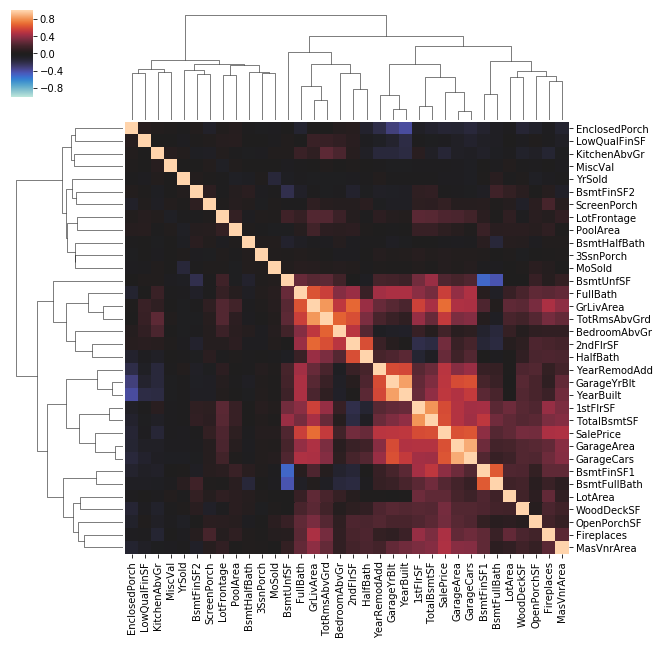

In [10]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)

In [11]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores[:10]

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
TotalBsmtSF     0.367449
GarageArea      0.359382
GarageCars      0.354152
BsmtQual        0.330803
KitchenQual     0.324679
Name: MI Scores, dtype: float64

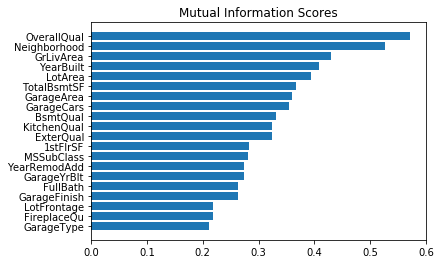

In [12]:
plot_mi_scores(mi_scores[:20])

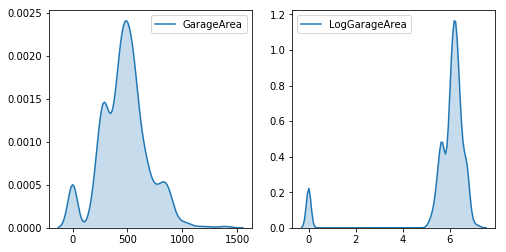

In [13]:
names = X.select_dtypes("float").columns
# candidates = 1,3
tmp = X.copy()
n = 5

tmp[f"Log{names[n]}"] = tmp[names[n]].apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(tmp[names[n]], shade=True, ax=axs[0])
sns.kdeplot(tmp[f"Log{names[n]}"], shade=True, ax=axs[1]);

In [14]:
# one-hot-encoding low-cardinality cols
def ohe_encode(df, cardinality=5):
    object_cols = df.select_dtypes(["object", "category"]).columns
    low_cardinality_cols = [col for col in object_cols if df[col].nunique() < cardinality]
    
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    X = pd.DataFrame(enc.fit_transform(df[low_cardinality_cols]))
    X.index = df.index
    return X

# Logarithms of numeric features. If a feature has a skewed distribution, applying a logarithm can help normalize it.
def log_normalizing(df, cols):
    X = pd.DataFrame()
    for col in cols:
        X[f"Log{col}"] = df[col].apply(np.log1p)
    return X

def math_transforms(df):
    X = pd.DataFrame()
    X["LivLotRatio"] = df["GrLivArea"] / df["LotArea"]
    X["Spaciousness"] = (df["1stFlrSF"] + df["2ndFlrSF"]) / df["TotRmsAbvGrd"]
    return X

def group_transforms(df):
    X = pd.DataFrame()
    #X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    X["MedQualArea"] = df.groupby("OverallQual")["GrLivArea"].transform("median")
    return X

def count_transforms(df):
    X = pd.DataFrame()
    features = ["WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"]
    X["PorchTypes"] = df[features].gt(0.0).sum(axis=1)
    return X

# clustering
def clustering_features(df, features, n_clusters=10):
  
    X_scaled = df[features].copy() # df.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis = 0)) / X_scaled.std(axis = 0)

    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X1 = pd.DataFrame(kmeans.fit_predict(X_scaled), columns = ["Cluster"], index=df.index)
    
    #centroids = kmeans.fit_transform(X_scaled)
    #cent_cols = [f"Centroid_{i}" for i in range(centroids.shape[1])]
    #X2 = pd.DataFrame(centroids, columns = cent_cols, index=df.index)
       
    return X1 # X1.join(X2)

In [15]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [16]:
# PCA to dataset

def pca_components(df, pca_features):
    X = pd.DataFrame()
    pca, X_pca, loadings = apply_pca(df[pca_features])
    X["PC1"] = X_pca["PC1"]
    X.index = df.index
    return X
    

def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df["Neighborhood"] == "Edwards") & (df["SaleCondition"] == "Partial")
    return X_new


In [17]:
def create_features(df, df_test=None):
    
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Mutual Information (scores == 0)
    X = drop_uninformative(X, mi_scores)

    #Transformations
    X = X.join(ohe_encode(X, cardinality=5))
    X = X.join(log_normalizing(X, ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'GarageArea']))
    X = X.join(math_transforms(X))
    X = X.join(group_transforms(X))
    X = X.join(count_transforms(X))
    
    # Clustering (can't find any useful combination)
    #cluster_features = ["GrLivArea", "YearBuilt", "LotArea", "TotalBsmtSF", "GarageArea"]
    #X = X.join(clustering_features(X, cluster_features))  

    # PCA
    pca_features = ["GarageArea", "YearRemodAdd", "TotalBsmtSF", "GrLivArea"]
    X = X.join(pca_components(X, pca_features))
    X = X.join(indicate_outliers(X))

    #X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    #encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    #X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    #if df_test is not None:
    #    X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, y, X_test
    else:
        return X, y

In [18]:
X_train, y, X_test = create_features(df_train, df_test)

score_dataset(X_train, y)

0.1368911005174795

Improvement! Let's have some model tuning

In [19]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 500, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params


[I 2022-01-23 20:56:27,720] Trial 0 finished with value: 0.12560598458233593 and parameters: {'max_depth': 5, 'learning_rate': 0.06520525738677899, 'n_estimators': 7498, 'min_child_weight': 10, 'colsample_bytree': 0.5137904668218467, 'subsample': 0.46194325685675786, 'reg_alpha': 0.000618374953146958, 'reg_lambda': 0.4334905864937758}. Best is trial 0 with value: 0.12560598458233593.
[I 2022-01-23 20:57:06,698] Trial 1 finished with value: 6.133210096077555 and parameters: {'max_depth': 5, 'learning_rate': 0.0001177698258436571, 'n_estimators': 5817, 'min_child_weight': 3, 'colsample_bytree': 0.9917343309849735, 'subsample': 0.5764559333681438, 'reg_alpha': 0.002098543129992967, 'reg_lambda': 55.54097203952576}. Best is trial 0 with value: 0.12560598458233593.
[I 2022-01-23 20:57:31,475] Trial 2 finished with value: 0.3937377536523425 and parameters: {'max_depth': 7, 'learning_rate': 0.01864296221427785, 'n_estimators': 5505, 'min_child_weight': 1, 'colsample_bytree': 0.380410635649403

In [21]:
#xgb_params
xgb_params = {'max_depth': 4,
 'learning_rate': 0.007004634899054686,
 'n_estimators': 6853,
 'min_child_weight': 4,
 'colsample_bytree': 0.5503046169686944,
 'subsample': 0.33395658882056023,
 'reg_alpha': 0.000599647352872223,
 'reg_lambda': 0.0012619516833126405
}

# output of optuna

In [22]:
score_dataset(X_train, y, model=XGBRegressor(**xgb_params))

0.11899487927820468

Improvement! 

In [23]:
X_train, y, X_test = create_features(df_train, df_test)

xgb = XGBRegressor(**xgb_params)

# final encoding
X_train = encode_categorical(X_train)
X_test = encode_categorical(X_test)

# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y))
predictions = np.exp(xgb.predict(X_test))

In [26]:
output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('./my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
